In [1]:
import os
import glob
from math import ceil

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg

%load_ext autoreload
%autoreload 2

In [2]:
results_dir = os.path.join(
    cfg.repo_root, '08_cell_line_prediction', 'results', 'tcga_ccle_nn_dropout_range'
)

num_genes = 8000
seed = 42
plot_gene = 'KRAS'

output_plots = True
output_plots_dir = os.path.join(
    cfg.repo_root, '08_cell_line_prediction', 'generalization_plots', 'nn_results'
)

In [3]:
dropout_dfs = {}

for dropout_file in glob.glob(
    os.path.join(results_dir,
                 plot_gene,
                 f'{plot_gene}_signal_mad_s{seed}_n{num_genes}_d*_classify_learning_curves.tsv.gz')
):
    dropout = (
        os.path.basename(dropout_file).split('_')[5].replace('d', '')
    )
    dropout_df = pd.read_csv(dropout_file, sep='\t', index_col=0).reset_index(drop=True)
    dropout_df['dropout'] = dropout
    dropout_dfs[dropout] = dropout_df

print(sorted(list(dropout_dfs.keys())))
dropout_dfs[list(dropout_dfs.keys())[0]].head()

['0.0', '0.05', '0.125', '0.25', '0.375', '0.5', '0.625', '0.75', '0.875', '0.95']


,epoch,fold,dataset,metric,value,dropout
0,1,0,train,aupr,0.571386,0.125
1,2,0,train,aupr,0.604804,0.125
2,3,0,train,aupr,0.655113,0.125
3,4,0,train,aupr,0.674217,0.125
4,5,0,train,aupr,0.708685,0.125


[0.0, 0.05, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 0.95]


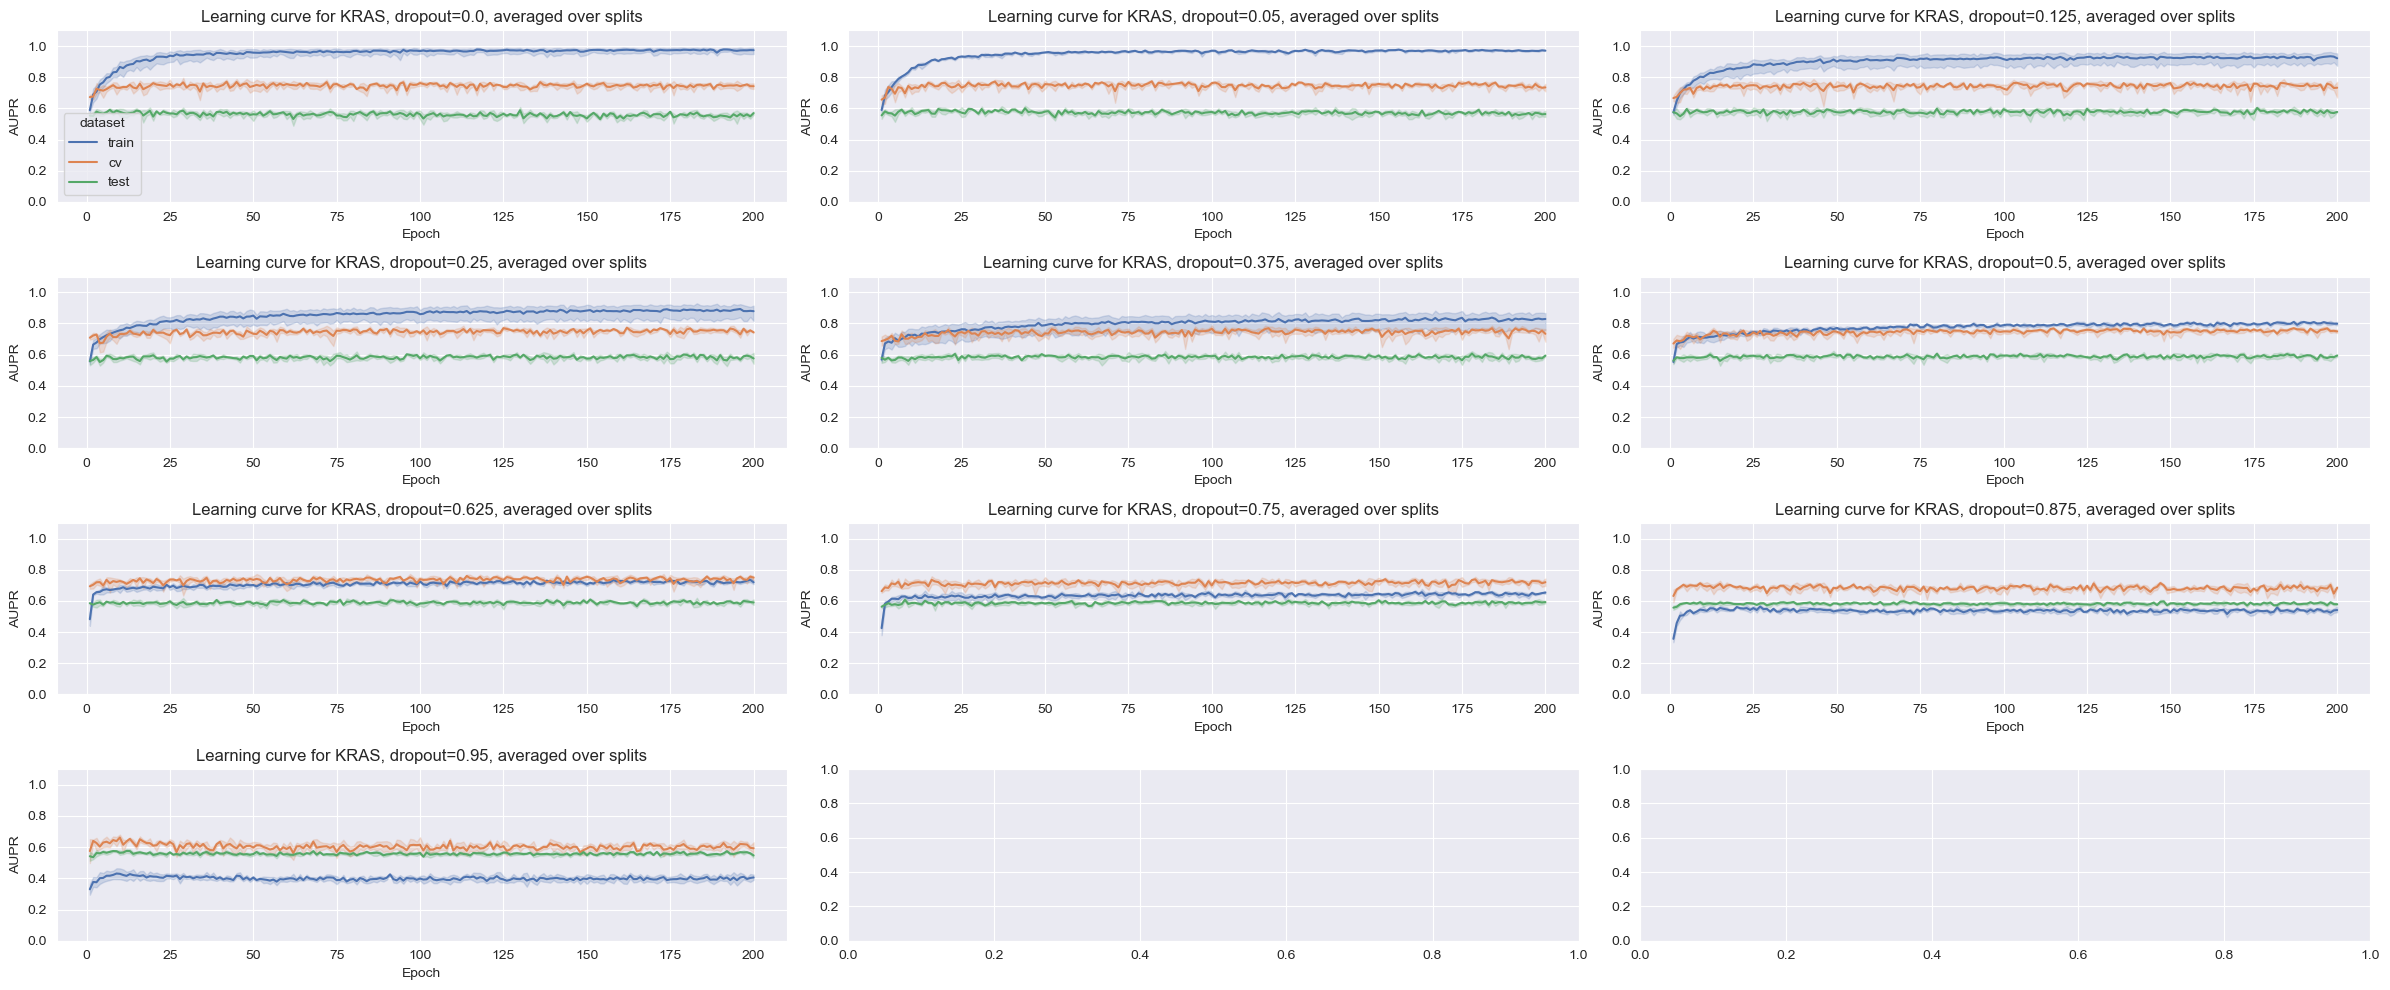

In [4]:
sns.set_style('whitegrid')
sns.set({'figure.figsize': (24, 10)})

dropout_vals = sorted(list([float(k) for k in dropout_dfs.keys()]))
print(dropout_vals)

fig, axarr = plt.subplots(ceil(len(dropout_vals) / 3), 3)

for ix, dropout in enumerate(dropout_vals):
    ax = axarr[ix // 3, ix % 3]
    if ix == 0:
        sns.lineplot(data=dropout_dfs[str(dropout)], x='epoch', y='value', hue='dataset', ax=ax)
    else:
        sns.lineplot(data=dropout_dfs[str(dropout)], x='epoch', y='value', hue='dataset', legend=False, ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUPR')
    ax.set_ylim(0, 1.1)
    ax.set_title(f'Learning curve for {plot_gene}, dropout={dropout}, averaged over splits')
    
plt.tight_layout()

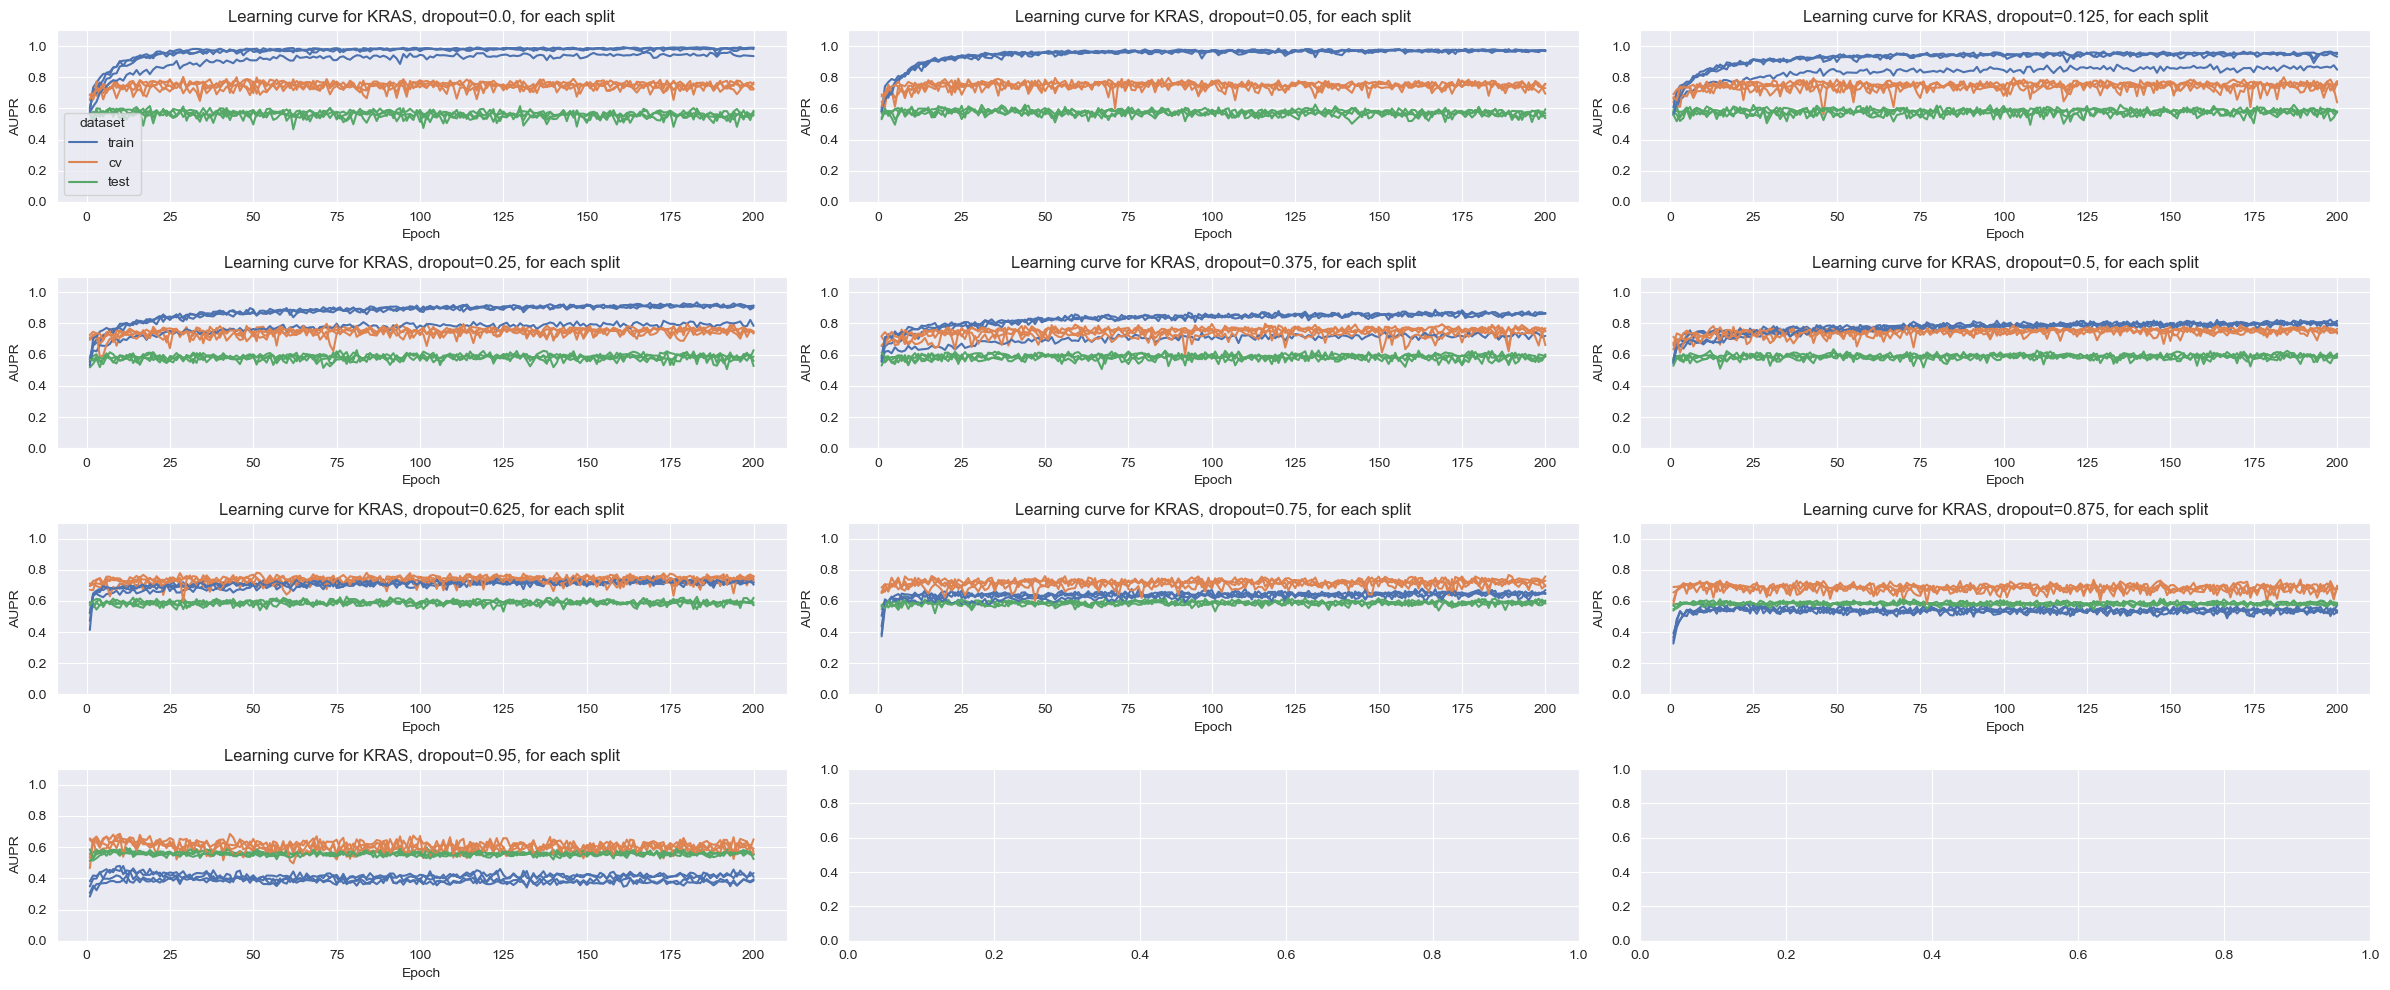

In [5]:
sns.set_style('whitegrid')
sns.set({'figure.figsize': (24, 10)})

fig, axarr = plt.subplots(ceil(len(dropout_vals) / 3), 3)

for dropout_ix, dropout in enumerate(dropout_vals):
    ax = axarr[dropout_ix // 3, dropout_ix % 3]
    dropout_df = dropout_dfs[str(dropout)]
    for fold_ix, fold in enumerate(dropout_df.fold.unique()):
        if dropout_ix == 0 and fold_ix == 0:
            sns.lineplot(data=dropout_df[dropout_df.fold == fold],
                         x='epoch', y='value', hue='dataset', ax=ax)
        else:
            sns.lineplot(data=dropout_df[dropout_df.fold == fold],
                         x='epoch', y='value', hue='dataset',
                         legend=False, ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUPR')
    ax.set_ylim(0, 1.1)
    ax.set_title(f'Learning curve for {plot_gene}, dropout={dropout}, for each split')

plt.tight_layout()

In [6]:
dropout_df = pd.concat(dropout_dfs.values())
print(dropout_df.shape)
dropout_df.head()

(24000, 6)


,epoch,fold,dataset,metric,value,dropout
0,1,0,train,aupr,0.571386,0.125
1,2,0,train,aupr,0.604804,0.125
2,3,0,train,aupr,0.655113,0.125
3,4,0,train,aupr,0.674217,0.125
4,5,0,train,aupr,0.708685,0.125


In [7]:
last_epoch = dropout_df.epoch.max()
perf_df = (dropout_df[dropout_df.epoch == last_epoch]
    .drop(columns=['epoch'])
)
                      
print(perf_df.shape)
perf_df.head()

(120, 5)


,fold,dataset,metric,value,dropout
199,0,train,aupr,0.848510,0.125
399,0,cv,aupr,0.638093,0.125
599,0,test,aupr,0.576086,0.125
799,1,train,aupr,0.957090,0.125
999,1,cv,aupr,0.775104,0.125


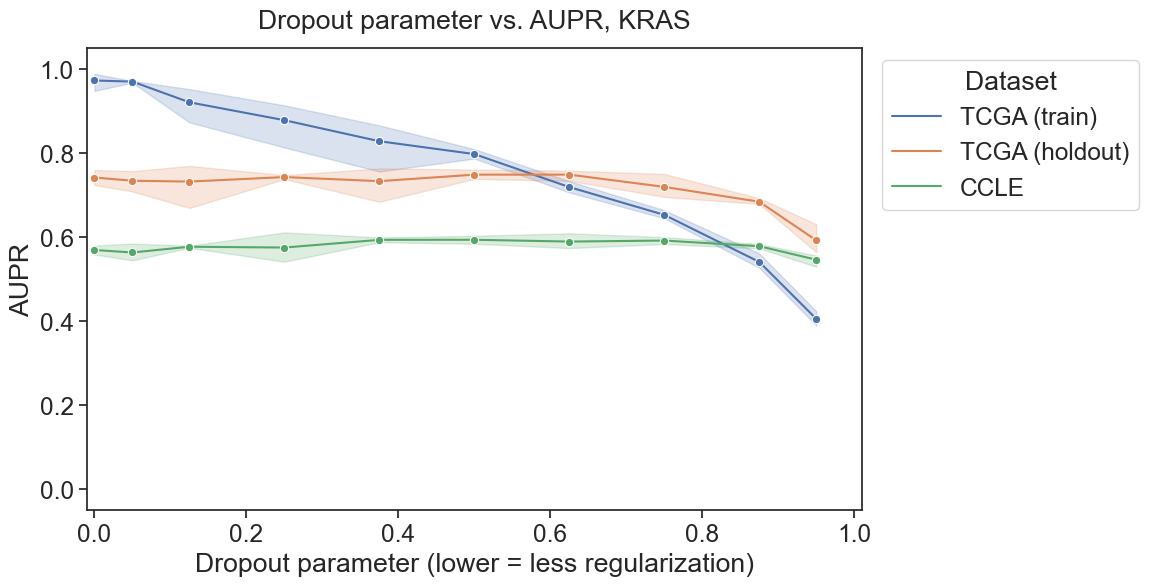

In [8]:
# plot dropout (as a float-valued variable) vs. performance
sns.set({'figure.figsize': (10, 6)})
sns.set_style('ticks')

plot_df = (perf_df
    .sort_values(by=['dropout'])
    .reset_index(drop=True)
)
plot_df.dropout = plot_df.dropout.astype(float)

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.lineplot(
        data=plot_df,
        x='dropout', y='value', hue='dataset',
        hue_order=['train', 'cv', 'test'],
        marker='o'
    )
    g.set(xlim=(-0.05, 1.05), ylim=(-0.05, 1.05))
    g.set_xlim(-0.01, 1.01)
    g.set_xlabel(f'Dropout parameter (lower = less regularization)')
    g.set_ylabel('AUPR')
        
    ax = plt.gca()
    legend_handles, _ = ax.get_legend_handles_labels()
    dataset_labels = ['TCGA (train)', 'TCGA (holdout)', 'CCLE'] 
    ax.legend(legend_handles, dataset_labels, title='Dataset')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1.01, 1))
    plt.title(f'Dropout parameter vs. AUPR, {plot_gene}', y=1.025)
    
if output_plots:
    os.makedirs(output_plots_dir, exist_ok=True)
    plt.savefig(os.path.join(output_plots_dir, f'{plot_gene}_nn_dropout_vs_perf.svg'), bbox_inches='tight')